<a href="https://colab.research.google.com/github/MyNameIsEldar/Picture_Finding_System_Demo/blob/main/Picture_Finding_System_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picture Finding System Demo


## Project Info

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке train_images содержатся изображения для тренировки модели.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.

Доля людей, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание соответствует изображению.
Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
Имя файла изображения.
Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

В папке test_images содержатся изображения для тестирования модели.

## Imports

In [129]:
!pip install transformers

In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torch import nn
from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.models import resnet50
from transformers import AutoTokenizer, BertTokenizer, BertModel

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

## Downloading Data

In [131]:
!wget https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip

--2023-07-14 10:03:07--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150987455 (144M) [application/zip]
Saving to: ‘dsplus_integrated_project_4.zip.1’

dsplus_integrated_p 100%[===================>] 143.99M  19.9MB/s    in 8.2s    

2023-07-14 10:03:16 (17.5 MB/s) - ‘dsplus_integrated_project_4.zip.1’ saved [150987455/150987455]



In [132]:
!unzip dsplus_integrated_project_4.zip

Archive:  dsplus_integrated_project_4.zip
replace to_upload/test_images.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [133]:
PATH = '/content/to_upload/'
TRAIN_IM_PATH = '/content/to_upload/train_images'
TEST_IM_PATH = '/content/to_upload/test_images'

## EDA

Посмотрим на все данные, которые предложены для работы

In [134]:
crowd_annotations = pd.read_table(PATH + 'CrowdAnnotations.tsv', header = None)
expert_annotations = pd.read_table(PATH + 'ExpertAnnotations.tsv', header = None)
test_images = pd.read_csv(PATH + 'test_images.csv')
train_dataset = pd.read_csv(PATH + 'train_dataset.csv')
test_queries = pd.read_csv(PATH + 'test_queries.csv', error_bad_lines=False)

<ipython-input-134-6931bb63e18f>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_queries = pd.read_csv(PATH + 'test_queries.csv', error_bad_lines=False)
Skipping line 73: expected 3 fields, saw 4



In [135]:
dataframes = [crowd_annotations, expert_annotations, test_images, train_dataset, test_queries]

for df in dataframes:
  print()
  display(df.head())

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


,,|query_id|query_text|image
0|1177994172_10d143cb8d.jpg#0|Two blonde boys,one in a camouflage shirt and the other in blue,are having a water fight .|1177994172_10d143c...
1|1177994172_10d143cb8d.jpg#1|Two boys are squirting water guns at each other .|1177994172_10d143cb8d.jpg,NaN,NaN
2|1177994172_10d143cb8d.jpg#2|Two boys spraying each other with water|1177994172_10d143cb8d.jpg,NaN,NaN
3|1177994172_10d143cb8d.jpg#3|Two children wearing jeans squirt water at each other .|1177994172_10d143cb8d.jpg,NaN,NaN
4|1177994172_10d143cb8d.jpg#4|Two young boys are squirting water at each other .|1177994172_10d143cb8d.jpg,NaN,NaN


Сразу видно, что есть ошибка с выводом `test_queries`. Поправим сепарацию

In [136]:
test_queries = pd.read_csv(PATH + 'test_queries.csv', sep='|', index_col=0)
test_queries

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


Теперь все предельно ясно и понятно, все на месте.

In [137]:
for df in dataframes:
  display(df.info())
  print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 499 entries, ('0|1177994172_10d143cb8d.jpg#0|Two blonde boys ', ' one in a camouflage shirt and the other in blue ') to ('499|989851184_9ef368e520.jpg#4|The black dog has a toy in its mouth and a person stands nearby .|989851184_9ef368e520.jpg', nan)
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   |query_id|query_text|image  7 non-null      object
dtypes: object(1)
memory usage: 26.7+ KB


None

### Annotations

Посмотрим на оценки запросов

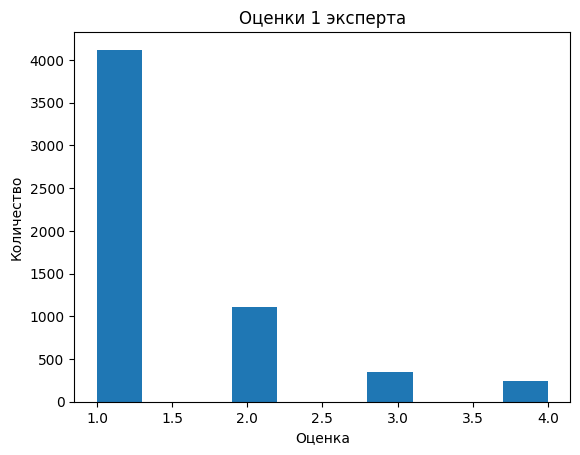

In [138]:
plt.hist(expert_annotations[2])
plt.title('Оценки 1 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

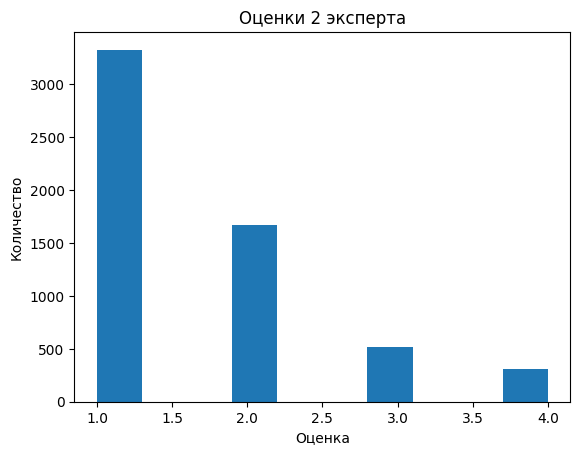

In [139]:
plt.hist(expert_annotations[3])
plt.title('Оценки 2 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

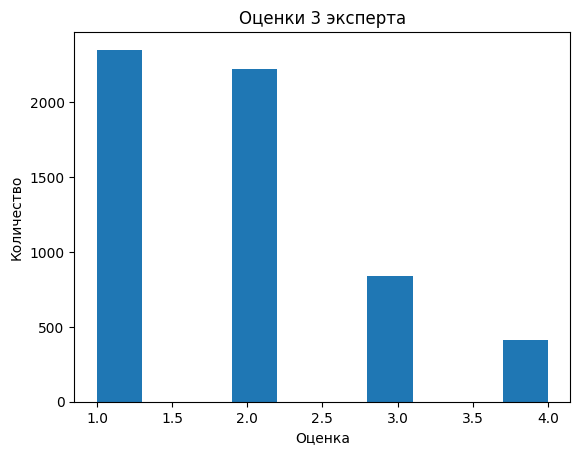

In [140]:
plt.hist(expert_annotations[4])
plt.title('Оценки 3 эксперта')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

По графикам можно сделать вывод о том, что куда больше неподходящий запросов, чем подходящих. Так же эксперты проранжировались по критичности оценки от наиболее критичного к менее критичному

Теперь посмотрим на оценки, полученные на краудсорсе. Здесь будем смотреть на процент, т.к. это наиболее репрезентативный параметр в данном датафрейме для анализа

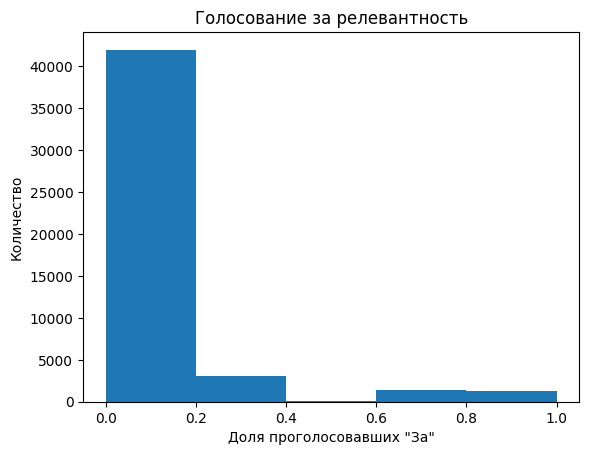

In [141]:
plt.hist(crowd_annotations[2], bins=5)
plt.title('Голосование за релевантность')
plt.ylabel('Количество')
plt.xlabel('Доля проголосовавших "За"')
plt.show()

Предположение, о том, что нерелевантных запросов куда больше релевантных подтвердилось. Много нулей в долях.

Изучим, сколько проголосовавших всего есть. Для этого посмотрим на столбец `0`

In [142]:
crowd_annotations[4].value_counts().sort_index()

0     1323
1     1371
2     3034
3    41219
4      665
5      176
6       42
Name: 4, dtype: int64

Стало ясно, что голосовавших не так много

Опишем процесс формирование таргета. Для более полного описания результатов оценки запросов будем использовать как оценки экспертов, так краудсорса.

Данные по экспертам преобразуем следующим образом. Возьмем среднее по оценкам трех экспертов, а затем поделим на 4. Таким образом мы получим значения от 0 до 1.

Затем сложим крауд и экспертов, заранее домножив на 0.3 и 0.7 соответсвенно. Таким образом мнение экспертов будет иметь больший вес чем крауд.

In [143]:
expert_annotations['mean_norm'] = expert_annotations[[2, 3, 4]].sum(axis=1) / 3 / 4

In [144]:
expert_annotations

,0,1,2,3,4,mean_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.250000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.333333
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.333333
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.416667
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.333333
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,0.250000
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,0.250000
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,0.333333
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,0.250000


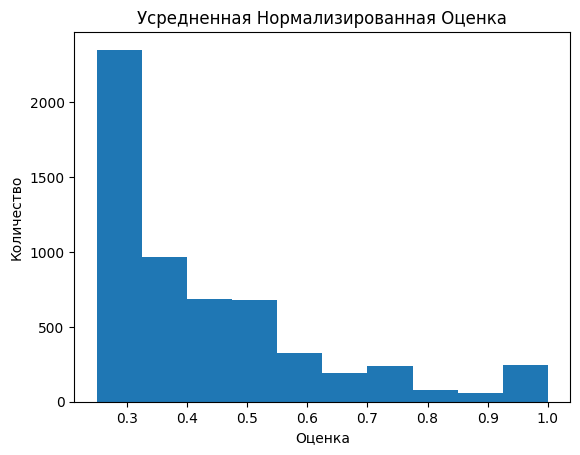

In [145]:
plt.hist(expert_annotations['mean_norm'])
plt.title('Усредненная Нормализированная Оценка')
plt.ylabel('Количество')
plt.xlabel('Оценка')
plt.show()

Запишем итоговыый таргет в тренировочный датасет

In [146]:
final_train_dataset = pd.merge(train_dataset, expert_annotations[[0, 1, 'mean_norm']], left_on=['image', 'query_id'], right_on=[0, 1])
final_train_dataset.head()

,image,query_id,query_text,0,1,mean_norm
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.250000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,0.250000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.416667
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,0.250000


In [147]:
final_train_dataset = pd.merge(final_train_dataset, crowd_annotations[[0, 1, 2]], left_on=['image', 'query_id'], right_on=[0, 1])
final_train_dataset.head()

,image,query_id,query_text,0_x,1_x,mean_norm,0_y,1_y,2
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.250000,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.0
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.416667,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,0.0
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,1.000000,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,1.0
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,0.583333,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,0.0
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,0.250000,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,0.0


In [148]:
final_train_dataset['target'] = final_train_dataset['mean_norm'] * 0.7 + final_train_dataset[2] * 0.3
final_train_dataset = final_train_dataset[['image', 'query_id', 'query_text', 'target']]
final_train_dataset.head()

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.291667
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.408333
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000


In [149]:
final_train_dataset.tail()

,image,query_id,query_text,target
2324,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,A man and a woman sitting on a dock .,0.233333
2325,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,A man stands at the entrance of Yerba Buena Ce...,0.350000
2326,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0.233333
2327,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.508333
2328,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.466667


## Data Cleaning

In [150]:
stop_words = [
    'kid',
    'child',
    'boy',
    'girl',
    'baby',
    'teen',
    'young',
    'newborn'
]

In [151]:
def find_stop_words(row):
  for word in stop_words:
    if word in row['query_text'].lower():
      return 1
  return 0

Применим фукнцию для того, чтобы понять, в каких описаниях есть стоп слова.

In [152]:
final_train_dataset['is_wrong'] = final_train_dataset.apply(find_stop_words, axis=1)
final_train_dataset.head()

<ipython-input-152-7fe558fb8450>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_dataset['is_wrong'] = final_train_dataset.apply(find_stop_words, axis=1)


,image,query_id,query_text,target,is_wrong
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.291667,1
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000,1
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.408333,1
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1


In [153]:
final_train_dataset.tail()

,image,query_id,query_text,target,is_wrong
2324,476759700_8911f087f8.jpg,1082379191_ec1e53f996.jpg#2,A man and a woman sitting on a dock .,0.233333,0
2325,561417861_8e25d0c0e8.jpg,410453140_5401bf659a.jpg#2,A man stands at the entrance of Yerba Buena Ce...,0.350000,0
2326,561940436_64d6fc125d.jpg,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,0.233333,0
2327,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,0.508333,1
2328,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,0.466667,0


In [154]:
final_train_dataset.sample(5)

,image,query_id,query_text,target,is_wrong
1527,3217187564_0ffd89dec1.jpg,2968182121_b3b491df85.jpg#2,Two greyhounds race .,0.625000,0
1116,3642220260_3aa8a52670.jpg,1772859261_236c09b861.jpg#2,A dog splashes through the water .,0.566667,0
1166,1561658940_a947f2446a.jpg,3627011534_485f667b10.jpg#2,A young girl is wearing a purple shirt and pin...,0.525000,1
1916,3655155990_b0e201dd3c.jpg,2541104331_a2d65cfa54.jpg#2,a dog pounces into the water .,0.625000,0
2120,2718495608_d8533e3ac5.jpg,3655074079_7df3812bc5.jpg#2,A naked woman wearing body paint riding a bicy...,0.291667,0


Теперь стоит удалить те картинки, для которых таргет 1 и `is_wrong` 1.
Это будут те картинки, для которых совпало описание, в котором есть синонимы слова child и их части.

Стоит обратить внимание на то, что этот подход достаточно тривиален и не будет работать в частных случаях. Например, если в описании картинки не сказано про детей, но они все же присутствуют (если ребенок попал на второй план изображения). Более правильным с точки зрения точности решения проблемы будет подход, при котором для чистки используются не только описания картинок, но и сами картинки. Можно было бы использовать модель, обученную на детекцию класса детей на изображении.

Так же для обработки описаний можно было бы использовать не просто чистку по части запрещенных слов, а полноценную модель. Например, можно было бы использовать предобученные на задачу QuestionAnswering модели и трансформеры.
Они могли бы помочь в тех ситуациях когда, наличие ребенка не описано явно ("маленький человек", в значении "ребенок").

Тогда вероятность того, что после чистки останутся данные, которые нельзя использовать уменьшится. Однако в нашем проекте рассматривается другая задача. Поэтому оставим реализованный подход и оставим упоминание о том, что это не единственный способ очистить данные)

In [155]:
final_train_dataset['target_rounded'] = final_train_dataset['target'].astype(float).round()

In [156]:
final_train_dataset = final_train_dataset.loc[(final_train_dataset['target_rounded'] + final_train_dataset['is_wrong']) < 2]

In [157]:
final_train_dataset.head()

,image,query_id,query_text,target,is_wrong,target_rounded
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1,0.0
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.291667,1,0.0
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.408333,1,0.0
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1,0.0
5,3741827382_71e93298d0.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.350000,1,0.0


Не забудем о тестовом датасете. Тут достаточно будет обозначить те строки, которые нам не подходят и удалить их.

In [158]:
test_queries['is_wrong'] = test_queries.apply(find_stop_words, axis=1)

In [159]:
test_queries = test_queries.loc[test_queries['is_wrong'] == 0]
test_queries.head()

,query_id,query_text,image,is_wrong
11,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going afte...,123997871_6a9ca987b1.jpg,0
13,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to ...,123997871_6a9ca987b1.jpg,0
14,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,123997871_6a9ca987b1.jpg,0
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg,0
16,1319634306_816f21677f.jpg#1,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg,0


In [160]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 11 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    327 non-null    object
 1   query_text  327 non-null    object
 2   image       327 non-null    object
 3   is_wrong    327 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 12.8+ KB


После чистки осталось всего 327 фото

## Image Vectorization

Приступим к веторизации картинок. Будем использовать предобученную модель ResNet50, инициализировать будем веса ImageNet. Т.к. нам нужно получить только векторное представление, то линейный слой из модели уберем.

In [161]:
resnet_model = resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [162]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Теперь уберем последний слой

In [163]:
resnet_model = nn.Sequential(*(list(resnet_model.children())[:-1]))
resnet_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [164]:
resnet_model.to('cuda')
resnet_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Загрузим изображения текст

In [165]:
final_train_dataset.head()

,image,query_id,query_text,target,is_wrong,target_rounded
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1,0.0
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.291667,1,0.0
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.408333,1,0.0
4,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.175000,1,0.0
5,3741827382_71e93298d0.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.350000,1,0.0


In [166]:
final_train_dataset.image

0       1056338697_4f7d7ce270.jpg
1       2447284966_d6bbdb4b6e.jpg
3       3030566410_393c36a6c5.jpg
4       3718964174_cb2dc1615e.jpg
5       3741827382_71e93298d0.jpg
                  ...            
2323     444481722_690d0cadcf.jpg
2324     476759700_8911f087f8.jpg
2325     561417861_8e25d0c0e8.jpg
2326     561940436_64d6fc125d.jpg
2328     929679367_ff8c7df2ee.jpg
Name: image, Length: 2211, dtype: object

In [167]:
transform = transforms.Compose([transforms.Resize(224),
                                 transforms.ToTensor()])

In [168]:
def train_images_to_vec(image_path):
  image = Image.open(TRAIN_IM_PATH + '/' + image_path).convert('RGB')
  image = transform(image)
  with torch.no_grad():
    image = resnet_model(image.to('cuda').unsqueeze(0))
  image = image.flatten().to('cpu')
  return image.numpy()

In [169]:
tqdm.pandas()
train_image_vectors = final_train_dataset['image'].progress_apply(train_images_to_vec)
train_image_vectors

100%|██████████| 2211/2211 [00:35<00:00, 62.56it/s]


0       [0.08834454, 0.31814983, 0.43366498, 0.3651692...
1       [0.48852623, 1.0082433, 0.18654163, 0.29012877...
3       [0.21591239, 0.5411522, 0.8238766, 1.1129537, ...
4       [0.3503969, 0.5708665, 1.533107, 0.04112771, 0...
5       [0.22926211, 0.48320544, 0.50504214, 0.2199328...
                              ...                        
2323    [0.19381233, 0.83563834, 0.89284605, 0.1905669...
2324    [0.11385174, 1.6038069, 0.6625584, 0.16457613,...
2325    [0.30484423, 0.59677035, 0.7887511, 0.62985426...
2326    [0.30725327, 0.596273, 0.7690562, 0.15498365, ...
2328    [0.34617883, 0.5773609, 1.0711677, 0.17800088,...
Name: image, Length: 2211, dtype: object

In [170]:
train_image_vectors.shape

(2211,)

In [171]:
train_image_vectors = np.array(train_image_vectors)

In [172]:
train_image_vectors.shape

(2211,)

In [173]:
pretrained = 'bert-base-uncased'

In [174]:
tokenizer = BertTokenizer.from_pretrained(pretrained)

In [175]:
bert_model = BertModel.from_pretrained(pretrained)
bert_model.to('cuda')
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [176]:
tokenized_texts = final_train_dataset['query_text'].progress_apply(tokenizer, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt").values

100%|██████████| 2211/2211 [00:01<00:00, 1685.64it/s]


In [177]:
with torch.no_grad():
  torch.cuda.empty_cache()
with torch.no_grad():
  train_query_vectors = np.array([bert_model(**tokenized_texts[i].to('cuda')) for i in tqdm(range(len(tokenized_texts)))])

100%|██████████| 2211/2211 [00:24<00:00, 89.31it/s]


Помотрим, как выглядит вывод модели для одного запроса

In [319]:
train_query_vectors[5]

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 3.0646e-01,  1.8740e-01, -3.1748e-01,  ..., -1.9276e-01,
           1.8112e-01,  5.7759e-01],
         [ 2.7737e-01, -2.2400e-01, -7.1288e-01,  ..., -1.8458e-01,
           2.0467e-02,  2.6872e-01],
         [ 3.0596e-01, -1.0687e+00, -3.5441e-01,  ..., -2.6509e-01,
          -2.7549e-01,  4.0387e-02],
         ...,
         [ 1.9966e-01, -1.2970e-01,  1.3907e-01,  ..., -3.5385e-04,
          -1.1748e-01,  4.2052e-02],
         [ 3.5982e-01,  3.5598e-02,  2.6712e-01,  ..., -1.8873e-02,
          -7.1427e-02,  9.0465e-02],
         [-1.9052e-01, -3.4186e-01,  3.0168e-02,  ...,  9.1001e-02,
           3.3905e-01, -2.7051e-01]]], device='cuda:0'), pooler_output=tensor([[-0.8634, -0.5801, -0.9694,  0.6043,  0.8911, -0.2952,  0.8389,  0.4438,
         -0.8267, -1.0000, -0.5103,  0.9817,  0.9846,  0.5914,  0.9304, -0.7139,
         -0.3719, -0.5787,  0.3400, -0.3775,  0.7118,  1.0000, -0.2011,  0.3439,
          0.5399

In [321]:
train_query_vectors[1][0].shape

torch.Size([1, 25, 768])

В last_hidden_state находятся тензоры, описывающие скрытое состояние на последнем слое для каждого токена. pooler_output описывает скрытое состояние для первого токена ([CLS]), к которму дополнительно применяется tanh фукнция активации.

Для того, чтобы получить необходимый нам вектор признаков достаточно использовать только вектор [CLS] токена, в котором зашита информация о всей поледовательности.

In [323]:
train_query_vectors[1][0].shape

torch.Size([1, 25, 768])

In [326]:
train_query = np.array([train_query_vectors[i][1].flatten().to('cpu').detach().numpy() for i in range(len(train_query_vectors))])
train_query.shape

(2211, 768)

Теперь создадим общий вектор признаков. Выделим таргеты

In [325]:
X = np.array([np.concatenate((train_query[i], train_image_vectors[i])) for i in range(len(train_query))])
X.shape

(2211, 21248)

Сразу определим `input_size`

In [183]:
input_size = 2816

In [184]:
y = final_train_dataset.target.to_numpy()
y.shape

(2211,)

Разобьем на тестовую и валидационную выборки

In [185]:
gss = GroupShuffleSplit(n_splits=len(final_train_dataset.image.value_counts()), test_size=0.3)

In [186]:
a, b = next(gss.split(X=X, y=y, groups=final_train_dataset.image))

In [187]:
train_index, val_index = next(gss.split(X=X, y=y, groups=final_train_dataset.image))

In [188]:
X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

In [189]:
X_train.shape

(1528, 2816)

Данные загружены и отвекторизированы. Размер каждого ветора признаков известен. Сделали его стандартным для правильной работы моделей. Теперь перейдем к обучению моделей.

## Models

В качестве моделей будем использовать обыкновенную линейную регрессию, градиенный бустинг и полносвязную нейронную сеть.

Со структурой нейронной сети определимся сразу, будем использвать общепринятый универсальный апроксиматор: 3 полносвязных слоя. В последнем слое - один нейрон.

Начнем с линейной регрессии

В качестве целевой метрики будем использовать `RMSE`. Наша цель - дать процент соответствия запроса картинке. Т.к. метрика - `RMSE`, то loss-функцией будет `MSE`. Задачу можно было бы перевести в вид бинарной классификации и выдавать не класс, а подобие вероятности, которое каждая модель отдает до того, как ответ преобразуется в вид 0 или 1, но остановимся на регрессии, т.к. так наше предсказание будет больше соответствовать мнению экспертов/крауда.

In [190]:
models_results = pd.DataFrame(columns=['linear_regression', 'gradient_boosting', 'FCNN'], index=['RMSE'])

### Linear Regression

In [191]:
linear_regression = LinearRegression()

In [192]:
linear_regression.fit(X_train, y_train)

LinearRegression()

In [193]:
reg_preds = linear_regression.predict(X_val)

In [194]:
mean_squared_error(y_val, reg_preds, squared=False)

0.7777392847518046

In [195]:
models_results['linear_regression'] = mean_squared_error(y_val, reg_preds, squared=False)

Выводы сделаем позже, а пока градиентный бустинг

### Gradient Boosting

In [196]:
gb = GradientBoostingRegressor(verbose=1)

In [197]:
gb.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0554            2.22m
         2           0.0535            2.20m
         3           0.0517            2.14m
         4           0.0500            1.99m
         5           0.0486            1.88m
         6           0.0472            1.81m
         7           0.0459            1.76m
         8           0.0448            1.71m
         9           0.0436            1.67m
        10           0.0427            1.64m
        20           0.0350            1.45m
        30           0.0303            1.27m
        40           0.0270            1.08m
        50           0.0246           53.37s
        60           0.0229           42.90s
        70           0.0207           32.35s
        80           0.0192           21.65s
        90           0.0179           10.80s
       100           0.0166            0.00s


GradientBoostingRegressor(verbose=1)

In [198]:
gb_preds = gb.predict(X_val)

In [199]:
mean_squared_error(y_val, gb_preds, squared=False)

0.22951980515205525

In [200]:
models_results['gradient_boosting'] = mean_squared_error(y_val, gb_preds, squared=False)

### Neural Network

In [286]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).type(torch.float32).to('cuda'), torch.tensor(y_train).type(torch.float32 ).to('cuda')
X_val_tensor, y_val_tensor = torch.tensor(X_val).type(torch.float32).to('cuda'), torch.tensor(y_val).type(torch.float32 ).to('cuda')

In [287]:
train_tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_tensor_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_tensor_dataloader = DataLoader(train_tensor_dataset,
                                     batch_size=32,
                                     shuffle=True)

val_tensor_dataloader = DataLoader(val_tensor_dataset,
                                     batch_size=32,
                                     shuffle=True)

In [288]:
class NeuralNet(nn.Module):
    """NN with 3 hidden layers, PReLu activations, with regularization"""

    def __init__(self, input_size,
                 hidden_size_1,
                 hidden_size_2,
                 hidden_size_3):
        super(NeuralNet, self).__init__()
        self.relu = nn.ReLU()
        self.prelu = nn.PReLU()
        self.dc = nn.Dropout(p=.3)
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bc1 = nn.BatchNorm1d(hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bc2 = nn.BatchNorm1d(hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bc3 = nn.BatchNorm1d(hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bc1(out)
        out = self.prelu(out)
        out = self.fc2(out)
        out = self.bc2(out)
        out = self.prelu(out)
        out = self.fc3(out)
        out = self.bc3(out)
        out = self.prelu(out)
        out = self.fc4(out)
        out = self.relu(out)
        return out

In [289]:
FCNN = NeuralNet(input_size, 3000, 1000, 1)

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(FCNN.parameters(), lr=learning_rate)

In [290]:
def model_training(model, train_loader, val_loader, num_epochs):
  total_step = len(train_loader)
  rmse_vals = []
  for epoch in tqdm(range(num_epochs)):
      model.train()
      for i, (X, y) in enumerate(train_loader):

          # Прямой проход
          outputs = model(X).flatten()
          loss = criterion(outputs, y)

          # Обратный проход
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if (i+1) % 25 == 0:
              rmse = mean_squared_error(y.cpu().detach().numpy(), outputs.cpu().detach().numpy(), squared=False)
              print ('Эпоха [{}/{}], Итерация [{}/{}], Значение функции потерь: {:.4f} RMSE: {}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(),
                            rmse))
              rmse_vals.append(rmse)

  plt.figure(figsize=(8,8))
  plt.plot(range(num_epochs), rmse_vals)
  plt.title('Neural Net Training Process')
  plt.xlabel('Epoch')
  plt.ylabel('Rmse')
  plt.show()

In [291]:
FCNN.to('cuda')

NeuralNet(
  (relu): ReLU()
  (prelu): PReLU(num_parameters=1)
  (dc): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=2816, out_features=3000, bias=True)
  (bc1): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=3000, out_features=1000, bias=True)
  (bc2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1000, out_features=1, bias=True)
  (bc3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1, out_features=1, bias=True)
)

  1%|          | 1/150 [00:00<00:30,  4.81it/s]

Эпоха [1/150], Итерация [25/48], Значение функции потерь: 0.2959 RMSE: 0.5439499020576477


  1%|▏         | 2/150 [00:00<00:34,  4.28it/s]

Эпоха [2/150], Итерация [25/48], Значение функции потерь: 0.1742 RMSE: 0.41731858253479004


  2%|▏         | 3/150 [00:00<00:34,  4.28it/s]

Эпоха [3/150], Итерация [25/48], Значение функции потерь: 0.1312 RMSE: 0.3622399866580963


  3%|▎         | 4/150 [00:00<00:33,  4.30it/s]

Эпоха [4/150], Итерация [25/48], Значение функции потерь: 0.0977 RMSE: 0.3126175105571747


  3%|▎         | 5/150 [00:01<00:33,  4.27it/s]

Эпоха [5/150], Итерация [25/48], Значение функции потерь: 0.0625 RMSE: 0.2500835657119751


  4%|▍         | 6/150 [00:01<00:33,  4.35it/s]

Эпоха [6/150], Итерация [25/48], Значение функции потерь: 0.0750 RMSE: 0.27394306659698486


  5%|▍         | 7/150 [00:01<00:33,  4.33it/s]

Эпоха [7/150], Итерация [25/48], Значение функции потерь: 0.0991 RMSE: 0.31474819779396057


  5%|▌         | 8/150 [00:01<00:32,  4.39it/s]

Эпоха [8/150], Итерация [25/48], Значение функции потерь: 0.0580 RMSE: 0.240884467959404


  6%|▌         | 9/150 [00:02<00:32,  4.39it/s]

Эпоха [9/150], Итерация [25/48], Значение функции потерь: 0.0526 RMSE: 0.22940564155578613


  7%|▋         | 10/150 [00:02<00:32,  4.37it/s]

Эпоха [10/150], Итерация [25/48], Значение функции потерь: 0.0556 RMSE: 0.2358803153038025


  7%|▋         | 11/150 [00:02<00:31,  4.36it/s]

Эпоха [11/150], Итерация [25/48], Значение функции потерь: 0.0404 RMSE: 0.20096158981323242


  8%|▊         | 12/150 [00:02<00:31,  4.37it/s]

Эпоха [12/150], Итерация [25/48], Значение функции потерь: 0.0527 RMSE: 0.22946184873580933


  9%|▊         | 13/150 [00:02<00:31,  4.36it/s]

Эпоха [13/150], Итерация [25/48], Значение функции потерь: 0.0412 RMSE: 0.20298439264297485


  9%|▉         | 14/150 [00:03<00:31,  4.38it/s]

Эпоха [14/150], Итерация [25/48], Значение функции потерь: 0.0433 RMSE: 0.20806583762168884


 10%|█         | 15/150 [00:03<00:30,  4.36it/s]

Эпоха [15/150], Итерация [25/48], Значение функции потерь: 0.0433 RMSE: 0.20798969268798828


 11%|█         | 16/150 [00:03<00:30,  4.35it/s]

Эпоха [16/150], Итерация [25/48], Значение функции потерь: 0.0305 RMSE: 0.17477886378765106


 11%|█▏        | 17/150 [00:03<00:30,  4.34it/s]

Эпоха [17/150], Итерация [25/48], Значение функции потерь: 0.0395 RMSE: 0.19875366985797882


 12%|█▏        | 18/150 [00:04<00:30,  4.36it/s]

Эпоха [18/150], Итерация [25/48], Значение функции потерь: 0.0357 RMSE: 0.18885521590709686


 13%|█▎        | 19/150 [00:04<00:29,  4.38it/s]

Эпоха [19/150], Итерация [25/48], Значение функции потерь: 0.0517 RMSE: 0.2273934930562973


 13%|█▎        | 20/150 [00:04<00:31,  4.17it/s]

Эпоха [20/150], Итерация [25/48], Значение функции потерь: 0.0456 RMSE: 0.21348662674427032


 14%|█▍        | 21/150 [00:04<00:30,  4.28it/s]

Эпоха [21/150], Итерация [25/48], Значение функции потерь: 0.0548 RMSE: 0.2339979112148285


 15%|█▍        | 22/150 [00:05<00:29,  4.30it/s]

Эпоха [22/150], Итерация [25/48], Значение функции потерь: 0.0343 RMSE: 0.18520709872245789


 15%|█▌        | 23/150 [00:05<00:29,  4.32it/s]

Эпоха [23/150], Итерация [25/48], Значение функции потерь: 0.0406 RMSE: 0.20152567327022552


 16%|█▌        | 24/150 [00:05<00:29,  4.33it/s]

Эпоха [24/150], Итерация [25/48], Значение функции потерь: 0.0318 RMSE: 0.17839783430099487


 17%|█▋        | 25/150 [00:05<00:28,  4.32it/s]

Эпоха [25/150], Итерация [25/48], Значение функции потерь: 0.0355 RMSE: 0.18833529949188232


 17%|█▋        | 26/150 [00:05<00:28,  4.34it/s]

Эпоха [26/150], Итерация [25/48], Значение функции потерь: 0.0208 RMSE: 0.14408165216445923


 18%|█▊        | 27/150 [00:06<00:28,  4.34it/s]

Эпоха [27/150], Итерация [25/48], Значение функции потерь: 0.0344 RMSE: 0.18534693121910095


 19%|█▊        | 28/150 [00:06<00:28,  4.31it/s]

Эпоха [28/150], Итерация [25/48], Значение функции потерь: 0.0650 RMSE: 0.25488126277923584


 19%|█▉        | 29/150 [00:06<00:27,  4.34it/s]

Эпоха [29/150], Итерация [25/48], Значение функции потерь: 0.0171 RMSE: 0.13070254027843475


 20%|██        | 30/150 [00:06<00:27,  4.30it/s]

Эпоха [30/150], Итерация [25/48], Значение функции потерь: 0.0217 RMSE: 0.14730103313922882


 21%|██        | 31/150 [00:07<00:27,  4.30it/s]

Эпоха [31/150], Итерация [25/48], Значение функции потерь: 0.0239 RMSE: 0.1544705331325531


 21%|██▏       | 32/150 [00:07<00:27,  4.33it/s]

Эпоха [32/150], Итерация [25/48], Значение функции потерь: 0.0310 RMSE: 0.17605556547641754


 22%|██▏       | 33/150 [00:07<00:27,  4.33it/s]

Эпоха [33/150], Итерация [25/48], Значение функции потерь: 0.0207 RMSE: 0.1439199000597


 23%|██▎       | 34/150 [00:07<00:26,  4.32it/s]

Эпоха [34/150], Итерация [25/48], Значение функции потерь: 0.0325 RMSE: 0.18024525046348572


 23%|██▎       | 35/150 [00:08<00:26,  4.33it/s]

Эпоха [35/150], Итерация [25/48], Значение функции потерь: 0.0315 RMSE: 0.1776174157857895


 24%|██▍       | 36/150 [00:08<00:26,  4.34it/s]

Эпоха [36/150], Итерация [25/48], Значение функции потерь: 0.0317 RMSE: 0.17816612124443054


 25%|██▍       | 37/150 [00:08<00:24,  4.53it/s]

Эпоха [37/150], Итерация [25/48], Значение функции потерь: 0.0167 RMSE: 0.12920792400836945


 25%|██▌       | 38/150 [00:08<00:24,  4.48it/s]

Эпоха [38/150], Итерация [25/48], Значение функции потерь: 0.0648 RMSE: 0.25459542870521545


 26%|██▌       | 39/150 [00:08<00:25,  4.39it/s]

Эпоха [39/150], Итерация [25/48], Значение функции потерь: 0.0291 RMSE: 0.17063367366790771


 27%|██▋       | 40/150 [00:09<00:24,  4.40it/s]

Эпоха [40/150], Итерация [25/48], Значение функции потерь: 0.0159 RMSE: 0.12622347474098206


 27%|██▋       | 41/150 [00:09<00:24,  4.42it/s]

Эпоха [41/150], Итерация [25/48], Значение функции потерь: 0.0228 RMSE: 0.15103282034397125


 28%|██▊       | 42/150 [00:09<00:24,  4.39it/s]

Эпоха [42/150], Итерация [25/48], Значение функции потерь: 0.0216 RMSE: 0.14712738990783691


 29%|██▊       | 43/150 [00:09<00:24,  4.39it/s]

Эпоха [43/150], Итерация [25/48], Значение функции потерь: 0.0210 RMSE: 0.14505741000175476


 29%|██▉       | 44/150 [00:10<00:24,  4.32it/s]

Эпоха [44/150], Итерация [25/48], Значение функции потерь: 0.0182 RMSE: 0.1349000781774521


 30%|███       | 45/150 [00:10<00:24,  4.34it/s]

Эпоха [45/150], Итерация [25/48], Значение функции потерь: 0.0185 RMSE: 0.13612894713878632


 31%|███       | 46/150 [00:10<00:23,  4.36it/s]

Эпоха [46/150], Итерация [25/48], Значение функции потерь: 0.0300 RMSE: 0.1731606125831604


 31%|███▏      | 47/150 [00:10<00:23,  4.37it/s]

Эпоха [47/150], Итерация [25/48], Значение функции потерь: 0.0136 RMSE: 0.11678504198789597


 32%|███▏      | 48/150 [00:11<00:23,  4.38it/s]

Эпоха [48/150], Итерация [25/48], Значение функции потерь: 0.0174 RMSE: 0.13200698792934418


 33%|███▎      | 49/150 [00:11<00:23,  4.39it/s]

Эпоха [49/150], Итерация [25/48], Значение функции потерь: 0.0152 RMSE: 0.12320735305547714


 33%|███▎      | 50/150 [00:11<00:23,  4.35it/s]

Эпоха [50/150], Итерация [25/48], Значение функции потерь: 0.0177 RMSE: 0.13310541212558746


 34%|███▍      | 51/150 [00:11<00:22,  4.34it/s]

Эпоха [51/150], Итерация [25/48], Значение функции потерь: 0.0132 RMSE: 0.11504562199115753


 35%|███▍      | 52/150 [00:11<00:22,  4.34it/s]

Эпоха [52/150], Итерация [25/48], Значение функции потерь: 0.0220 RMSE: 0.148212730884552


 35%|███▌      | 53/150 [00:12<00:22,  4.40it/s]

Эпоха [53/150], Итерация [25/48], Значение функции потерь: 0.0168 RMSE: 0.1294885277748108


 36%|███▌      | 54/150 [00:12<00:22,  4.33it/s]

Эпоха [54/150], Итерация [25/48], Значение функции потерь: 0.0267 RMSE: 0.16339513659477234


 37%|███▋      | 55/150 [00:12<00:21,  4.35it/s]

Эпоха [55/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.08345383405685425


 37%|███▋      | 56/150 [00:12<00:21,  4.35it/s]

Эпоха [56/150], Итерация [25/48], Значение функции потерь: 0.0066 RMSE: 0.08151288330554962


 38%|███▊      | 57/150 [00:13<00:21,  4.36it/s]

Эпоха [57/150], Итерация [25/48], Значение функции потерь: 0.0124 RMSE: 0.11128508299589157


 39%|███▊      | 58/150 [00:13<00:20,  4.39it/s]

Эпоха [58/150], Итерация [25/48], Значение функции потерь: 0.0078 RMSE: 0.08814200013875961


 39%|███▉      | 59/150 [00:13<00:20,  4.37it/s]

Эпоха [59/150], Итерация [25/48], Значение функции потерь: 0.0140 RMSE: 0.11811299622058868


 40%|████      | 60/150 [00:13<00:20,  4.36it/s]

Эпоха [60/150], Итерация [25/48], Значение функции потерь: 0.0211 RMSE: 0.14532870054244995


 41%|████      | 61/150 [00:14<00:20,  4.28it/s]

Эпоха [61/150], Итерация [25/48], Значение функции потерь: 0.0078 RMSE: 0.0882716104388237


 41%|████▏     | 62/150 [00:14<00:20,  4.35it/s]

Эпоха [62/150], Итерация [25/48], Значение функции потерь: 0.0179 RMSE: 0.13366174697875977


 42%|████▏     | 63/150 [00:14<00:19,  4.36it/s]

Эпоха [63/150], Итерация [25/48], Значение функции потерь: 0.0129 RMSE: 0.11364592611789703


 43%|████▎     | 64/150 [00:14<00:19,  4.35it/s]

Эпоха [64/150], Итерация [25/48], Значение функции потерь: 0.0084 RMSE: 0.09175815433263779


 43%|████▎     | 65/150 [00:14<00:19,  4.36it/s]

Эпоха [65/150], Итерация [25/48], Значение функции потерь: 0.0124 RMSE: 0.11144429445266724


 44%|████▍     | 66/150 [00:15<00:19,  4.35it/s]

Эпоха [66/150], Итерация [25/48], Значение функции потерь: 0.0108 RMSE: 0.10400384664535522


 45%|████▍     | 67/150 [00:15<00:19,  4.33it/s]

Эпоха [67/150], Итерация [25/48], Значение функции потерь: 0.0140 RMSE: 0.11818072199821472


 45%|████▌     | 68/150 [00:15<00:18,  4.32it/s]

Эпоха [68/150], Итерация [25/48], Значение функции потерь: 0.0110 RMSE: 0.10466883331537247


 46%|████▌     | 69/150 [00:15<00:18,  4.32it/s]

Эпоха [69/150], Итерация [25/48], Значение функции потерь: 0.0119 RMSE: 0.10912009328603745


 47%|████▋     | 70/150 [00:16<00:18,  4.33it/s]

Эпоха [70/150], Итерация [25/48], Значение функции потерь: 0.0081 RMSE: 0.08984515070915222


 47%|████▋     | 71/150 [00:16<00:18,  4.34it/s]

Эпоха [71/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.08378209918737411


 48%|████▊     | 72/150 [00:16<00:17,  4.36it/s]

Эпоха [72/150], Итерация [25/48], Значение функции потерь: 0.0088 RMSE: 0.09396661818027496


 49%|████▊     | 73/150 [00:16<00:17,  4.36it/s]

Эпоха [73/150], Итерация [25/48], Значение функции потерь: 0.0235 RMSE: 0.15322494506835938


 49%|████▉     | 74/150 [00:17<00:17,  4.26it/s]

Эпоха [74/150], Итерация [25/48], Значение функции потерь: 0.0116 RMSE: 0.10766001045703888


 50%|█████     | 75/150 [00:17<00:17,  4.39it/s]

Эпоха [75/150], Итерация [25/48], Значение функции потерь: 0.0086 RMSE: 0.09294700622558594


 51%|█████     | 76/150 [00:17<00:16,  4.38it/s]

Эпоха [76/150], Итерация [25/48], Значение функции потерь: 0.0132 RMSE: 0.11478237062692642


 51%|█████▏    | 77/150 [00:17<00:16,  4.37it/s]

Эпоха [77/150], Итерация [25/48], Значение функции потерь: 0.0106 RMSE: 0.10284154862165451


 52%|█████▏    | 78/150 [00:17<00:16,  4.36it/s]

Эпоха [78/150], Итерация [25/48], Значение функции потерь: 0.0173 RMSE: 0.1314530074596405


 53%|█████▎    | 79/150 [00:18<00:16,  4.36it/s]

Эпоха [79/150], Итерация [25/48], Значение функции потерь: 0.0151 RMSE: 0.12280318886041641


 53%|█████▎    | 80/150 [00:18<00:16,  4.21it/s]

Эпоха [80/150], Итерация [25/48], Значение функции потерь: 0.0096 RMSE: 0.0980345755815506


 54%|█████▍    | 81/150 [00:18<00:16,  4.26it/s]

Эпоха [81/150], Итерация [25/48], Значение функции потерь: 0.0078 RMSE: 0.08805689215660095


 55%|█████▍    | 82/150 [00:18<00:15,  4.29it/s]

Эпоха [82/150], Итерация [25/48], Значение функции потерь: 0.0063 RMSE: 0.07940194755792618


 55%|█████▌    | 83/150 [00:19<00:15,  4.24it/s]

Эпоха [83/150], Итерация [25/48], Значение функции потерь: 0.0039 RMSE: 0.06225505843758583


 56%|█████▌    | 84/150 [00:19<00:15,  4.36it/s]

Эпоха [84/150], Итерация [25/48], Значение функции потерь: 0.0177 RMSE: 0.13309229910373688


 57%|█████▋    | 85/150 [00:19<00:14,  4.37it/s]

Эпоха [85/150], Итерация [25/48], Значение функции потерь: 0.0189 RMSE: 0.13748054206371307


 57%|█████▋    | 86/150 [00:19<00:14,  4.33it/s]

Эпоха [86/150], Итерация [25/48], Значение функции потерь: 0.0121 RMSE: 0.11021484434604645


 58%|█████▊    | 87/150 [00:20<00:14,  4.34it/s]

Эпоха [87/150], Итерация [25/48], Значение функции потерь: 0.0089 RMSE: 0.0941329300403595


 59%|█████▊    | 88/150 [00:20<00:14,  4.28it/s]

Эпоха [88/150], Итерация [25/48], Значение функции потерь: 0.0117 RMSE: 0.10803878307342529


 59%|█████▉    | 89/150 [00:20<00:14,  4.32it/s]

Эпоха [89/150], Итерация [25/48], Значение функции потерь: 0.0069 RMSE: 0.0830826386809349


 60%|██████    | 90/150 [00:20<00:13,  4.30it/s]

Эпоха [90/150], Итерация [25/48], Значение функции потерь: 0.0061 RMSE: 0.07793892174959183


 61%|██████    | 91/150 [00:20<00:13,  4.30it/s]

Эпоха [91/150], Итерация [25/48], Значение функции потерь: 0.0048 RMSE: 0.06944822520017624


 61%|██████▏   | 92/150 [00:21<00:13,  4.30it/s]

Эпоха [92/150], Итерация [25/48], Значение функции потерь: 0.0201 RMSE: 0.14173771440982819


 62%|██████▏   | 93/150 [00:21<00:13,  4.29it/s]

Эпоха [93/150], Итерация [25/48], Значение функции потерь: 0.0120 RMSE: 0.10934888571500778


 63%|██████▎   | 94/150 [00:21<00:13,  4.27it/s]

Эпоха [94/150], Итерация [25/48], Значение функции потерь: 0.0076 RMSE: 0.08709773421287537


 63%|██████▎   | 95/150 [00:21<00:12,  4.28it/s]

Эпоха [95/150], Итерация [25/48], Значение функции потерь: 0.0106 RMSE: 0.10288884490728378


 64%|██████▍   | 96/150 [00:22<00:12,  4.38it/s]

Эпоха [96/150], Итерация [25/48], Значение функции потерь: 0.0087 RMSE: 0.09310450404882431


 65%|██████▍   | 97/150 [00:22<00:11,  4.49it/s]

Эпоха [97/150], Итерация [25/48], Значение функции потерь: 0.0069 RMSE: 0.08302322030067444


 65%|██████▌   | 98/150 [00:22<00:11,  4.46it/s]

Эпоха [98/150], Итерация [25/48], Значение функции потерь: 0.0085 RMSE: 0.09227010607719421


 66%|██████▌   | 99/150 [00:22<00:11,  4.39it/s]

Эпоха [99/150], Итерация [25/48], Значение функции потерь: 0.0045 RMSE: 0.06692084670066833


 67%|██████▋   | 100/150 [00:23<00:11,  4.41it/s]

Эпоха [100/150], Итерация [25/48], Значение функции потерь: 0.0076 RMSE: 0.08703584223985672


 67%|██████▋   | 101/150 [00:23<00:11,  4.38it/s]

Эпоха [101/150], Итерация [25/48], Значение функции потерь: 0.0103 RMSE: 0.10169728845357895


 68%|██████▊   | 102/150 [00:23<00:11,  4.35it/s]

Эпоха [102/150], Итерация [25/48], Значение функции потерь: 0.0032 RMSE: 0.056333500891923904


 69%|██████▊   | 103/150 [00:23<00:10,  4.35it/s]

Эпоха [103/150], Итерация [25/48], Значение функции потерь: 0.0129 RMSE: 0.11379685997962952


 69%|██████▉   | 104/150 [00:23<00:10,  4.37it/s]

Эпоха [104/150], Итерация [25/48], Значение функции потерь: 0.0055 RMSE: 0.07448498159646988


 70%|███████   | 105/150 [00:24<00:10,  4.36it/s]

Эпоха [105/150], Итерация [25/48], Значение функции потерь: 0.0079 RMSE: 0.08876116573810577


 71%|███████   | 106/150 [00:24<00:10,  4.36it/s]

Эпоха [106/150], Итерация [25/48], Значение функции потерь: 0.0074 RMSE: 0.08600612729787827


 71%|███████▏  | 107/150 [00:24<00:09,  4.35it/s]

Эпоха [107/150], Итерация [25/48], Значение функции потерь: 0.0066 RMSE: 0.08154600113630295


 72%|███████▏  | 108/150 [00:24<00:09,  4.33it/s]

Эпоха [108/150], Итерация [25/48], Значение функции потерь: 0.0056 RMSE: 0.07492546737194061


 73%|███████▎  | 109/150 [00:25<00:09,  4.34it/s]

Эпоха [109/150], Итерация [25/48], Значение функции потерь: 0.0043 RMSE: 0.06542693078517914


 73%|███████▎  | 110/150 [00:25<00:09,  4.34it/s]

Эпоха [110/150], Итерация [25/48], Значение функции потерь: 0.0065 RMSE: 0.08058630675077438


 74%|███████▍  | 111/150 [00:25<00:08,  4.37it/s]

Эпоха [111/150], Итерация [25/48], Значение функции потерь: 0.0065 RMSE: 0.08076471090316772


 75%|███████▍  | 112/150 [00:25<00:08,  4.37it/s]

Эпоха [112/150], Итерация [25/48], Значение функции потерь: 0.0153 RMSE: 0.12356461584568024


 75%|███████▌  | 113/150 [00:25<00:08,  4.38it/s]

Эпоха [113/150], Итерация [25/48], Значение функции потерь: 0.0360 RMSE: 0.18981154263019562


 76%|███████▌  | 114/150 [00:26<00:08,  4.38it/s]

Эпоха [114/150], Итерация [25/48], Значение функции потерь: 0.0070 RMSE: 0.0836302787065506


 77%|███████▋  | 115/150 [00:26<00:08,  4.37it/s]

Эпоха [115/150], Итерация [25/48], Значение функции потерь: 0.0036 RMSE: 0.05965571105480194


 77%|███████▋  | 116/150 [00:26<00:07,  4.37it/s]

Эпоха [116/150], Итерация [25/48], Значение функции потерь: 0.0119 RMSE: 0.10926904529333115


 78%|███████▊  | 117/150 [00:26<00:07,  4.36it/s]

Эпоха [117/150], Итерация [25/48], Значение функции потерь: 0.0094 RMSE: 0.09679990261793137


 79%|███████▊  | 118/150 [00:27<00:07,  4.35it/s]

Эпоха [118/150], Итерация [25/48], Значение функции потерь: 0.0046 RMSE: 0.0675058662891388


 79%|███████▉  | 119/150 [00:27<00:07,  4.34it/s]

Эпоха [119/150], Итерация [25/48], Значение функции потерь: 0.0052 RMSE: 0.0720728188753128


 80%|████████  | 120/150 [00:27<00:06,  4.38it/s]

Эпоха [120/150], Итерация [25/48], Значение функции потерь: 0.0108 RMSE: 0.10383229702711105


 81%|████████  | 121/150 [00:27<00:06,  4.34it/s]

Эпоха [121/150], Итерация [25/48], Значение функции потерь: 0.0107 RMSE: 0.10353176295757294


 81%|████████▏ | 122/150 [00:28<00:06,  4.36it/s]

Эпоха [122/150], Итерация [25/48], Значение функции потерь: 0.0111 RMSE: 0.10527043044567108


 82%|████████▏ | 123/150 [00:28<00:06,  4.37it/s]

Эпоха [123/150], Итерация [25/48], Значение функции потерь: 0.0034 RMSE: 0.05832440033555031


 83%|████████▎ | 124/150 [00:28<00:06,  4.33it/s]

Эпоха [124/150], Итерация [25/48], Значение функции потерь: 0.0046 RMSE: 0.06751584261655807


 83%|████████▎ | 125/150 [00:28<00:05,  4.32it/s]

Эпоха [125/150], Итерация [25/48], Значение функции потерь: 0.0081 RMSE: 0.0899214819073677


 84%|████████▍ | 126/150 [00:28<00:05,  4.36it/s]

Эпоха [126/150], Итерация [25/48], Значение функции потерь: 0.0109 RMSE: 0.10423222184181213


 85%|████████▍ | 127/150 [00:29<00:05,  4.33it/s]

Эпоха [127/150], Итерация [25/48], Значение функции потерь: 0.0035 RMSE: 0.058996036648750305


 85%|████████▌ | 128/150 [00:29<00:05,  4.33it/s]

Эпоха [128/150], Итерация [25/48], Значение функции потерь: 0.0061 RMSE: 0.07807447761297226


 86%|████████▌ | 129/150 [00:29<00:04,  4.34it/s]

Эпоха [129/150], Итерация [25/48], Значение функции потерь: 0.0063 RMSE: 0.07908739894628525


 87%|████████▋ | 130/150 [00:29<00:04,  4.36it/s]

Эпоха [130/150], Итерация [25/48], Значение функции потерь: 0.0095 RMSE: 0.09752985090017319


 87%|████████▋ | 131/150 [00:30<00:04,  4.35it/s]

Эпоха [131/150], Итерация [25/48], Значение функции потерь: 0.0051 RMSE: 0.0710844025015831


 88%|████████▊ | 132/150 [00:30<00:04,  4.37it/s]

Эпоха [132/150], Итерация [25/48], Значение функции потерь: 0.0061 RMSE: 0.07825838774442673


 89%|████████▊ | 133/150 [00:30<00:03,  4.33it/s]

Эпоха [133/150], Итерация [25/48], Значение функции потерь: 0.0092 RMSE: 0.09606434404850006


 89%|████████▉ | 134/150 [00:30<00:03,  4.36it/s]

Эпоха [134/150], Итерация [25/48], Значение функции потерь: 0.0020 RMSE: 0.045111458748579025


 90%|█████████ | 135/150 [00:31<00:03,  4.34it/s]

Эпоха [135/150], Итерация [25/48], Значение функции потерь: 0.0123 RMSE: 0.11071531474590302


 91%|█████████ | 136/150 [00:31<00:03,  4.35it/s]

Эпоха [136/150], Итерация [25/48], Значение функции потерь: 0.0062 RMSE: 0.07886704802513123


 91%|█████████▏| 137/150 [00:31<00:02,  4.35it/s]

Эпоха [137/150], Итерация [25/48], Значение функции потерь: 0.0067 RMSE: 0.08179906755685806


 92%|█████████▏| 138/150 [00:31<00:02,  4.34it/s]

Эпоха [138/150], Итерация [25/48], Значение функции потерь: 0.0048 RMSE: 0.06908444315195084


 93%|█████████▎| 139/150 [00:31<00:02,  4.36it/s]

Эпоха [139/150], Итерация [25/48], Значение функции потерь: 0.0087 RMSE: 0.09348893910646439


 93%|█████████▎| 140/150 [00:32<00:02,  4.21it/s]

Эпоха [140/150], Итерация [25/48], Значение функции потерь: 0.0039 RMSE: 0.06272230297327042


 94%|█████████▍| 141/150 [00:32<00:02,  4.22it/s]

Эпоха [141/150], Итерация [25/48], Значение функции потерь: 0.0025 RMSE: 0.049705103039741516


 95%|█████████▍| 142/150 [00:32<00:01,  4.28it/s]

Эпоха [142/150], Итерация [25/48], Значение функции потерь: 0.0036 RMSE: 0.05987913906574249


 95%|█████████▌| 143/150 [00:32<00:01,  4.32it/s]

Эпоха [143/150], Итерация [25/48], Значение функции потерь: 0.0066 RMSE: 0.08128152787685394


 96%|█████████▌| 144/150 [00:33<00:01,  4.30it/s]

Эпоха [144/150], Итерация [25/48], Значение функции потерь: 0.0034 RMSE: 0.058346301317214966


 97%|█████████▋| 145/150 [00:33<00:01,  4.33it/s]

Эпоха [145/150], Итерация [25/48], Значение функции потерь: 0.0027 RMSE: 0.052399106323719025


 97%|█████████▋| 146/150 [00:33<00:00,  4.32it/s]

Эпоха [146/150], Итерация [25/48], Значение функции потерь: 0.0055 RMSE: 0.07431042194366455


 98%|█████████▊| 147/150 [00:33<00:00,  4.32it/s]

Эпоха [147/150], Итерация [25/48], Значение функции потерь: 0.0057 RMSE: 0.07517554610967636


 99%|█████████▊| 148/150 [00:34<00:00,  4.28it/s]

Эпоха [148/150], Итерация [25/48], Значение функции потерь: 0.0074 RMSE: 0.08611766993999481


 99%|█████████▉| 149/150 [00:34<00:00,  4.33it/s]

Эпоха [149/150], Итерация [25/48], Значение функции потерь: 0.0195 RMSE: 0.139791339635849


100%|██████████| 150/150 [00:34<00:00,  4.34it/s]

Эпоха [150/150], Итерация [25/48], Значение функции потерь: 0.0034 RMSE: 0.058009590953588486


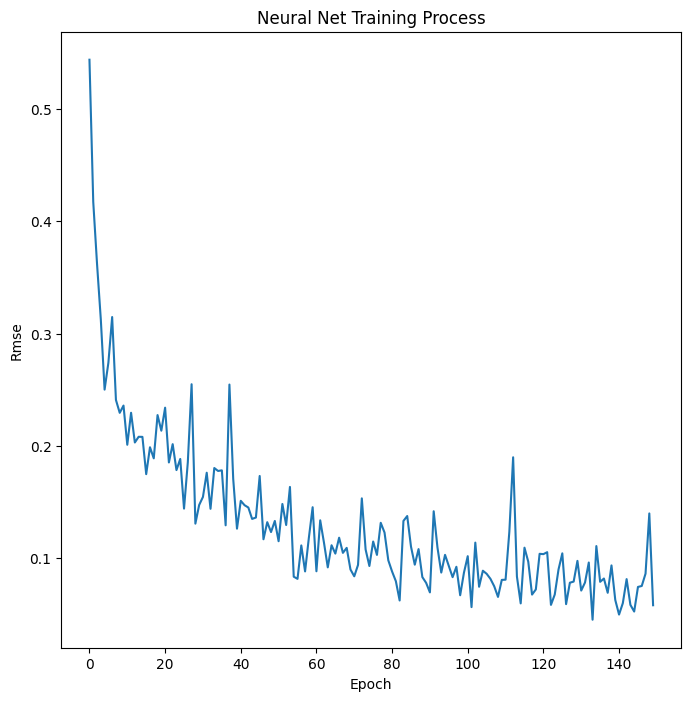

In [292]:
model_training(FCNN, train_tensor_dataloader, val_tensor_dataloader, 150)

In [293]:
FCNN.to('cpu')
val_out = FCNN(torch.tensor(X_val))

mean_squared_error(y_val, val_out.detach().numpy())

0.07308475418948475

In [294]:
models_results['FCNN'] = mean_squared_error(y_val, val_out.detach().numpy())

### Results

In [295]:
models_results

,linear_regression,gradient_boosting,FCNN
RMSE,0.777739,0.22952,0.073085


Полносвязная нейронная сеть показала наилучший результат. Проведем тестирование модели.

## Testing


Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

In [296]:
test_images.head()

,image,vector
0,3356748019_2251399314.jpg,"[0.6528109, 0.6387547, 0.09824896, 0.24505779,..."
1,2887171449_f54a2b9f39.jpg,"[0.28963217, 0.34629604, 1.3050839, 0.05714867..."
2,3089107423_81a24eaf18.jpg,"[0.010204707, 0.7312735, 0.26823097, 0.6412577..."
3,1429546659_44cb09cbe2.jpg,"[0.20565389, 0.7177862, 0.8327788, 0.026637614..."
4,1177994172_10d143cb8d.jpg,"[0.06826933, 1.211225, 0.7042716, 0.04582752, ..."


Преобразуем фото в векторы. Для этого напишем функцию

In [297]:
def test_images_to_vec(image_path):
  image = Image.open(TEST_IM_PATH + '/' + image_path).convert('RGB')
  image = transform(image)
  with torch.no_grad():
    image = resnet_model(image.to('cuda').unsqueeze(0))
  image = image.flatten().to('cpu')
  return image.numpy()

In [298]:
tqdm.pandas()
test_image_vectors = test_images['image'].progress_apply(test_images_to_vec)
test_image_vectors

100%|██████████| 100/100 [00:01<00:00, 56.26it/s]


0     [0.6528109, 0.6387547, 0.09824896, 0.24505779,...
1     [0.28963217, 0.34629604, 1.3050839, 0.05714867...
2     [0.010204707, 0.7312735, 0.26823097, 0.6412577...
3     [0.20565389, 0.7177862, 0.8327788, 0.026637614...
4     [0.06826933, 1.211225, 0.7042716, 0.04582752, ...
                            ...                        
95    [0.19748539, 0.7097712, 0.28096902, 0.31891903...
96    [1.0053996, 1.0327722, 1.1933779, 0.06320181, ...
97    [0.34538183, 0.75039923, 1.7617097, 0.00870572...
98    [0.31079915, 0.47419053, 1.0735494, 0.01596276...
99    [0.24625795, 0.36894244, 0.5249184, 0.7308684,...
Name: image, Length: 100, dtype: object

In [299]:
test_image_vectors.shape

(100,)

Соеденим все, что получилось в один датафрейм для более удобной работы

In [300]:
test_image_vectors = np.array(test_image_vectors)

In [301]:
test_image_vectors.shape

(100,)

In [302]:
test_images['vector'] = test_image_vectors
test_images.head()

,image,vector
0,3356748019_2251399314.jpg,"[0.6528109, 0.6387547, 0.09824896, 0.24505779,..."
1,2887171449_f54a2b9f39.jpg,"[0.28963217, 0.34629604, 1.3050839, 0.05714867..."
2,3089107423_81a24eaf18.jpg,"[0.010204707, 0.7312735, 0.26823097, 0.6412577..."
3,1429546659_44cb09cbe2.jpg,"[0.20565389, 0.7177862, 0.8327788, 0.026637614..."
4,1177994172_10d143cb8d.jpg,"[0.06826933, 1.211225, 0.7042716, 0.04582752, ..."


Теперь разберемся с запросами

In [303]:
test_queries.head()

,query_id,query_text,image,is_wrong
11,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going afte...,123997871_6a9ca987b1.jpg,0
13,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to ...,123997871_6a9ca987b1.jpg,0
14,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,123997871_6a9ca987b1.jpg,0
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg,0
16,1319634306_816f21677f.jpg#1,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg,0


Выберем 10 из них и преобразем в векторы

In [304]:
ten_test_queries = test_queries.sample(10)
ten_test_queries

,query_id,query_text,image,is_wrong
388,3520936130_9e90872560.jpg#3,two people sit on a park bench .,3520936130_9e90872560.jpg,0
431,404850242_3a55a4c874.jpg#1,An Asian woman is taking a photograph outside ...,404850242_3a55a4c874.jpg,0
16,1319634306_816f21677f.jpg#1,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg,0
365,3487131146_9d3aca387a.jpg#0,A group of men stands near a tree as a racing ...,3487131146_9d3aca387a.jpg,0
319,3396275223_ee080df8b5.jpg#4,Three people are doing ballet exercises in ext...,3396275223_ee080df8b5.jpg,0
37,1745110280_0cbff5e273.jpg#2,A sad looking dog sitting next to shrubs .,1745110280_0cbff5e273.jpg,0
366,3487131146_9d3aca387a.jpg#1,A race car kicks up dirt and dust on a gravel ...,3487131146_9d3aca387a.jpg,0
266,3184031654_34b5c4ffe1.jpg#1,Two Muslim woman wearing their head scarves an...,3184031654_34b5c4ffe1.jpg,0
358,3466891862_9afde75568.jpg#3,The small dog returns with his stick proudly .,3466891862_9afde75568.jpg,0
152,2687672606_275169c35d.jpg#2,A woman wears a colorful shirt and a lot of je...,2687672606_275169c35d.jpg,0


In [305]:
tokenized_test_texts = ten_test_queries['query_text'].progress_apply(tokenizer, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt").values

100%|██████████| 10/10 [00:00<00:00, 1355.54it/s]


In [306]:
with torch.no_grad():
  torch.cuda.empty_cache()
  test_query_vectors = np.array([bert_model(**tokenized_test_texts[i].to('cuda')) for i in tqdm(range(len(tokenized_test_texts)))])

100%|██████████| 10/10 [00:00<00:00, 81.61it/s]


In [307]:
test_query = np.array([test_query_vectors[i][1].flatten().to('cpu').detach().numpy() for i in range(len(test_query_vectors))])
test_query.shape

(10, 768)

Напишем фукнцию для поиска наиболее релевантного изображения

In [308]:
def find_image(query, test_images):

  result = {}

  tokenized_query = tokenizer(query, truncation=True,
                          padding="max_length",
                          max_length=25,
                          return_tensors="pt")
  with torch.no_grad():
    torch.cuda.empty_cache()
    tokenized_query = bert_model(**tokenized_query.to('cuda'))

  text_vector = tokenized_query[1].flatten().to('cpu').detach().numpy()
  # image_vec = np.array(image_vec)
  for i in range(len(test_images)):

    image_vec = test_images['vector'][i]
    image_path = test_images['image'][i]

    X_vec = np.concatenate((text_vector, image_vec))
    X_vec = X_vec.reshape(1, -1)

    with torch.no_grad():
      FCNN.eval()
      result[image_path] = FCNN(torch.tensor(X_vec)).numpy()[0][0]

  result = sorted(result.items(), key=lambda x:x[1], reverse=True)

  best_image = Image.open(TEST_IM_PATH + '/' + image_path)
  best_image.show()
  print(result[0][1])
  print(query)

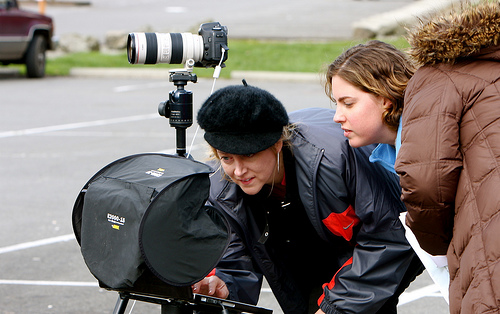

0.81869173
The small dog returns with his stick proudly .


In [311]:
find_image(ten_test_queries['query_text'][358], test_images)